In [1]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy import sparse

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# Load data
CSV_PATH = "DataAnalyzed/pe_features_multi.csv"
df = pd.read_csv(CSV_PATH)
print("Samples per class:\n", df['label'].value_counts())

Samples per class:
 label
Winwebsec     4400
Zbot          2100
Mediyes       1450
Benign         980
Zeroaccess     690
Locker         330
Name: count, dtype: int64


In [4]:
# Handle imports text
import_cols = [c for c in df.columns if c.startswith("import_")]
if import_cols:
    df['imports_text'] = df[import_cols].fillna("").astype(str).apply(
        lambda row: " ".join([t for t in row if t and t != 'nan']), axis=1
    )


In [5]:
# Drop unneeded
drop_like = [c for c in df.columns if c.lower() in ('md5','filename','filepath','file_path')]
df = df.drop(columns=[c for c in drop_like if c in df.columns])

obj_cols = df.select_dtypes(include='object').columns.tolist()
for c in obj_cols:
    if c not in ('imports_text', 'label'):
        df = df.drop(columns=[c])

In [6]:
# Encode labels (multi-class)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['label'])
print("Classes:", le.classes_)
df = df.drop(columns=['label'])

Classes: ['Benign' 'Locker' 'Mediyes' 'Winwebsec' 'Zbot' 'Zeroaccess']


In [7]:
# Numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if 'imports_text' not in df.columns:
    df['imports_text'] = ""

In [8]:
# Preprocessing
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

MAX_IMPORT_FEATURES = 500
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, numeric_cols),
    ('imp', CountVectorizer(max_features=MAX_IMPORT_FEATURES, token_pattern=r"(?u)\b\w+\b"), 'imports_text')
], remainder='drop', sparse_threshold=0.3)

In [9]:
# Split
X_train_df, X_test_df, y_train, y_test = train_test_split(
    df, y, test_size=0.2, stratify=y, random_state=42
)

preprocessor.fit(X_train_df)
X_train_trans = preprocessor.transform(X_train_df)
X_test_trans  = preprocessor.transform(X_test_df)

if sparse.issparse(X_train_trans):
    X_train = X_train_trans.toarray()
    X_test  = X_test_trans.toarray()
else:
    X_train = X_train_trans
    X_test  = X_test_trans

print("Feature matrix shape:", X_train.shape)

Feature matrix shape: (7960, 586)


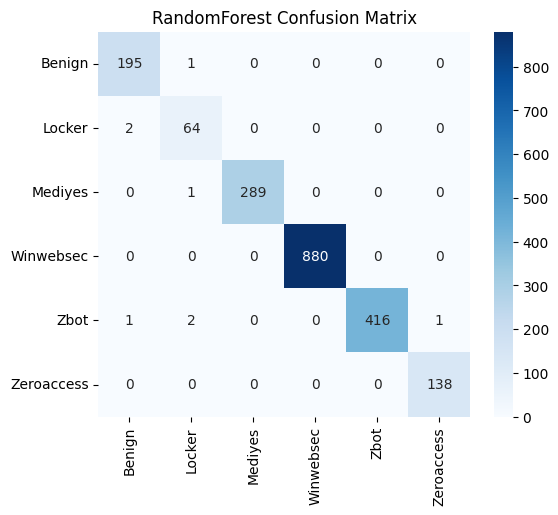

=== RandomForest Report ===
              precision    recall  f1-score   support

      Benign       0.98      0.99      0.99       196
      Locker       0.94      0.97      0.96        66
     Mediyes       1.00      1.00      1.00       290
   Winwebsec       1.00      1.00      1.00       880
        Zbot       1.00      0.99      1.00       420
  Zeroaccess       0.99      1.00      1.00       138

    accuracy                           1.00      1990
   macro avg       0.99      0.99      0.99      1990
weighted avg       1.00      1.00      1.00      1990

[+] Saved RandomForest model, preprocessor, and label encoder.


In [10]:
# RandomForest
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

cm_rf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("RandomForest Confusion Matrix")
plt.show()

print("=== RandomForest Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

joblib.dump(rf, "rf_pe_model.joblib")
joblib.dump(preprocessor, "preprocessor.joblib")
joblib.dump(le, "label_encoder.joblib")
print("[+] Saved RandomForest model, preprocessor, and label encoder.")

In [11]:
# PyTorch MLP
num_classes = len(le.classes_)

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, out_dim)
        )
    def forward(self, x):
        return self.net(x)

In [12]:
model = MLP(X_train.shape[1], num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

In [14]:
class_sample_count = np.bincount(y_train)
weights = 1.0 / class_sample_count
samples_weight = weights[y_train]
samples_weight = torch.from_numpy(samples_weight.astype(np.float32))
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

In [15]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, sampler=sampler)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=256, shuffle=False)

In [16]:
EPOCHS = 10
history = {"loss": []}

In [17]:
for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    history["loss"].append(avg_loss)
    print(f"Epoch {epoch:02d} | loss={avg_loss:.4f}")

Epoch 01 | loss=0.3095
Epoch 02 | loss=0.0444
Epoch 03 | loss=0.0217
Epoch 04 | loss=0.0153
Epoch 05 | loss=0.0116
Epoch 06 | loss=0.0141
Epoch 07 | loss=0.0088
Epoch 08 | loss=0.0068
Epoch 09 | loss=0.0041
Epoch 10 | loss=0.0081


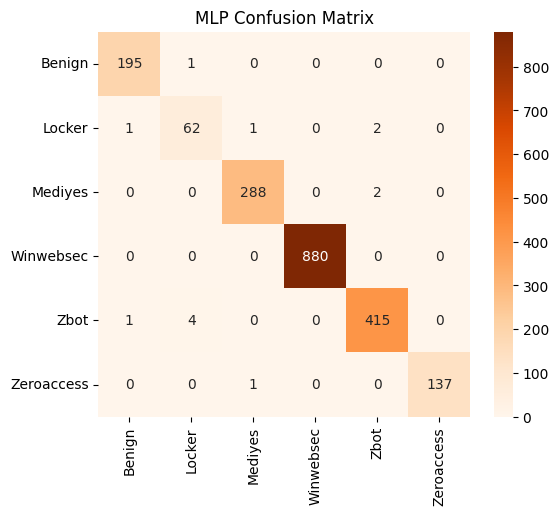

=== PyTorch MLP Report ===
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99       196
      Locker       0.93      0.94      0.93        66
     Mediyes       0.99      0.99      0.99       290
   Winwebsec       1.00      1.00      1.00       880
        Zbot       0.99      0.99      0.99       420
  Zeroaccess       1.00      0.99      1.00       138

    accuracy                           0.99      1990
   macro avg       0.98      0.98      0.98      1990
weighted avg       0.99      0.99      0.99      1990

[+] Saved PyTorch model.


In [18]:
# Evaluate
model.eval()
preds = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        pred = out.argmax(dim=1).cpu().numpy()
        preds.extend(pred.tolist())

cm_mlp = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Oranges", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("MLP Confusion Matrix")
plt.show()

print("=== PyTorch MLP Report ===")
print(classification_report(y_test, preds, target_names=le.classes_))

torch.save(model.state_dict(), "pe_mlp.pt")
print("[+] Saved PyTorch model.")


Cross-validation scores: [0.9968593  0.98932161 0.99434673 0.99623116 0.99434673]
Mean CV accuracy: 0.9942 (± 0.0026)


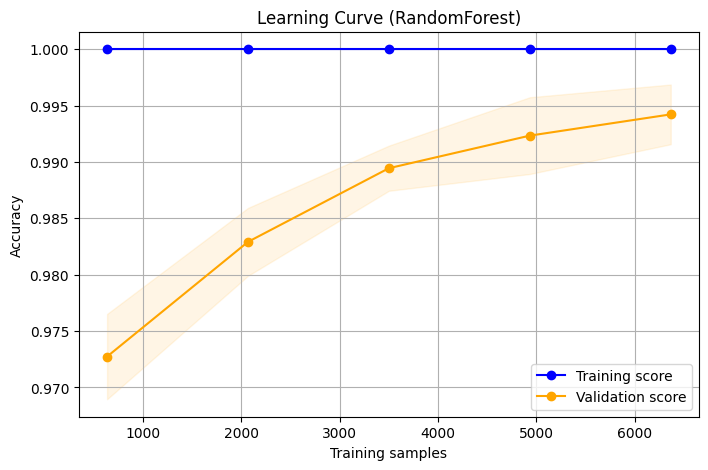

In [19]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
import matplotlib.pyplot as plt
import numpy as np

# --- Cross-validation for RandomForest ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_cv = RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight='balanced', random_state=42)

cv_scores = cross_val_score(rf_cv, X_train, y_train, cv=cv, scoring="accuracy")
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy: %.4f (± %.4f)" % (cv_scores.mean(), cv_scores.std()))

# --- Learning Curve ---
train_sizes, train_scores, val_scores = learning_curve(
    rf_cv, X_train, y_train, cv=cv, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, val_mean, 'o-', color="orange", label="Validation score")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1, color="orange")
plt.title("Learning Curve (RandomForest)")
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

     


In [20]:
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

train_acc = rf.score(X_train, y_train)
test_acc  = rf.score(X_test, y_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")


Train acc: 1.0000, Test acc: 0.9960


Chia moi phan cho 1 client(3 hoac 5)